<a href="https://colab.research.google.com/github/Abel-kaiki/Modelling/blob/main/type_NN_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries used in this project

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model

#Colab drive mount
from google.colab import drive
drive.mount("/content/drive")

#Load dataset
path = '/content/drive/MyDrive/ColabNotebooks/Datasets/R_W_Wine_quality.csv'
data = pd.read_csv(path)

Mounted at /content/drive


In [2]:
#Preparing dataframe - Splitting
# Separate inputs and outputs
inputs = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
data['Id'] = data.index
X = data[['Id'] + inputs] # include Id for tracking

#Need to convert 'type' to numerical (float OR binary)
data['type_int'] = (data['type'] == 'Red') #Red = True (1), White = False (0)
data['type_int'] = data['type_int'].astype(float)
data['quality'] = data['quality'].astype(float)

y = data[['quality','type_int']]
quality_min = min(data['quality'])
quality_max = max(data['quality'])
quality_range = quality_max - quality_min + 1 #Including min value

# Split data into training and testing sets, retaining IDs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# test_size : testing-training splits. 0.2 = 20% reserved for testing.

In [3]:
#Preparing df - Scaling
# fit and transform, scale between 1 and 0
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[inputs])
X_test_scaled = scaler.fit_transform(X_test[inputs])
num_classes = len(y.columns)

y_qual = y['quality'].values.reshape(-1, 1)
y_obj = scaler.fit(y_qual)

# y scaling (quality)
#y_train_scaled = scaler.transform(y_train)
#y_test_scaled = MinMaxScaler().transform(y_test)

#as dataframe
#y_train_scaled = pd.DataFrame(y_train_scaled, columns=['quality', 'type'])
#y_test_scaled = pd.DataFrame(y_test_scaled, columns=['quality', 'type'])

#y_train_scaled_nd = MinMaxScaler().fit_transform(y_train)
#y_test_scaled_nd = MinMaxScaler().fit_transform(y_test)

#num_classes

In [15]:
#Build model

#Sequential model cannot do multi-output, See: https://keras.io/guides/functional_api/#models-with-multiple-inputs-and-outputs
# In our case we need a softmax output for the quality, and a sigmoid output for the binary


model = Sequential([
    Dense(6, activation='relu', input_shape=(len(inputs),)), #First hidden layer with 64 neurons, relu activation function
    Dense(3, activation='relu'), # second hidden layer with 32 neurons
    Dense(2, activation='sigmoid') #output layer for classification (softmax for multiclass, sigmoid for binary)
])

# Initialise layers
#input_layer = Input(shape=(len(inputs),))
#hidden = Dense(6, activation='relu')(input_layer)
#hidden = Dense(16, activation='relu')(hidden)
#output1 = Dense(1, activation='sigmoid')(hidden)
#output2 = Dense(1, activation='sigmoid')(hidden)

##
#model = Model(inputs=input_layer, outputs=[output1, output2]) #multi-output
#model = Sequential(inputs=input_layer, outputs=output1)

#Compiling
#sgd=SGD(lr=0.9) use this if you want to change lr in SGD
#Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) use this if you want to change lr in Adam, default lr = 0.001
opti = Adam(learning_rate= 0.0001)
#model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy','binary_crossentropy']) #multi-output
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.compile(optimizer = opti, loss='sparse_categorical_crossentropy')

In [17]:
#Fitting model
model.fit(X_train_scaled, y_train['type_int'], validation_split=0.2, batch_size = 15, epochs = 200)
#[print(i.shape, i.dtype) for i in model.inputs]

Epoch 1/200
278/278 [==============================] - 3s 4ms/step - loss: 0.6760 - val_loss: 0.6688
Epoch 2/200
278/278 [==============================] - 3s 10ms/step - loss: 0.6596 - val_loss: 0.6518
Epoch 3/200
278/278 [==============================] - 1s 3ms/step - loss: 0.6419 - val_loss: 0.6327
Epoch 4/200
278/278 [==============================] - 1s 2ms/step - loss: 0.6227 - val_loss: 0.6138
Epoch 5/200
278/278 [==============================] - 3s 9ms/step - loss: 0.6037 - val_loss: 0.5947
Epoch 6/200
278/278 [==============================] - 1s 2ms/step - loss: 0.5842 - val_loss: 0.5752
Epoch 7/200
278/278 [==============================] - 1s 3ms/step - loss: 0.5644 - val_loss: 0.5555
Epoch 8/200
278/278 [==============================] - 1s 3ms/step - loss: 0.5443 - val_loss: 0.5355
Epoch 9/200
278/278 [==============================] - 3s 12ms/step - loss: 0.5243 - val_loss: 0.5157
Epoch 10/200
278/278 [==============================] - 1s 2ms/step - loss: 0.5043 - val_

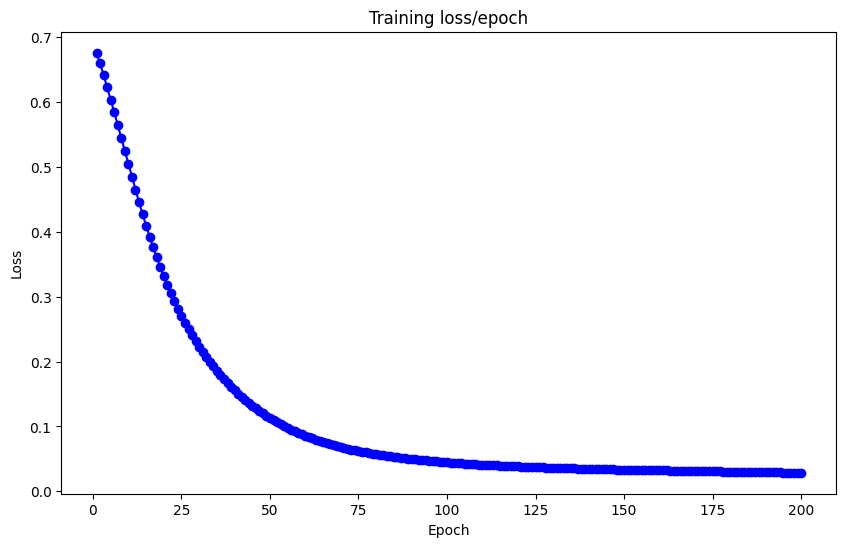

In [18]:
# Extract losses for training datasets
training_loss = model.history.history['loss']
epochs = range(1, len(training_loss) + 1)

# Plot training loss
plt.figure(figsize=(10,6))
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.title('Training loss/epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
#Evaluate model - type
#Use trained model to make predictions based on scaled test data
predictions = model.predict(X_test_scaled)
preds_type = predictions.argmax(axis=1)
#y_obj = MinMaxScaler().fit(y_test_scaled_nd[0].reshape(-1,1))
#predicted_quality = y_obj.inverse_transform(predictions)


41/41 [==============================] - 1s 22ms/step


In [27]:
#transform numerical class indices back to original labels
#predicted_labels = LabelEncoder.inverse_transform(predicted_quality)

#Actual quality for test data
actual_type = y_test['type_int'].values

#Calculate accuracy
correct_predictions = (preds_type == actual_type).sum()
accuracy = correct_predictions / len(actual_type)
print(accuracy*100, '% accurate')


#pred_range = preds - actual_quality
#rmin = min(pred_range)
#rmax = max(pred_range)

#in_range = 100*((pred_range == 1).sum() + (pred_range == -1).sum())/(len(pred_range) - (pred_range == 0).sum())
#in_range2 = (pred_range == 0).sum()/((pred_range == -1).sum() + (pred_range == 1).sum())
#print(in_range, '% of erroneous predicted qualities are +-1 of actual quality')
#print(in_range2, ': ratio between correct/incorrect by +-1')
#print(min(training_loss))

80.38461538461539 % accurate
